# Brain Tumor Detection

In [ ]:
# imports & setup
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
#  dataset paths & basic params
base_dir = '/content/Brain_Tumor'
train_dir = os.path.join(base_dir, '/content/Brain_Tumor/Dataset/Training')
test_dir  = os.path.join(base_dir, '/content/Brain_Tumor/Dataset/Testing')

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

print("Train classes (example):", os.listdir(train_dir))
print("Test classes (example):", os.listdir(test_dir))

# Count images
def count_images(folder):
    total = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.png','.jpg','.jpeg')):
                total += 1
    return total

print("Train images:", count_images(train_dir))
print("Test images:", count_images(test_dir))

Train classes (example): ['no tumor', 'tumor']
Test classes (example): ['no tumor', 'tumor']
Train images: 8277
Test images: 1816


In [ ]:
# Data generators (with augmentation) and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 6622 images belonging to 2 classes.
Found 1655 images belonging to 2 classes.
Found 1816 images belonging to 2 classes.


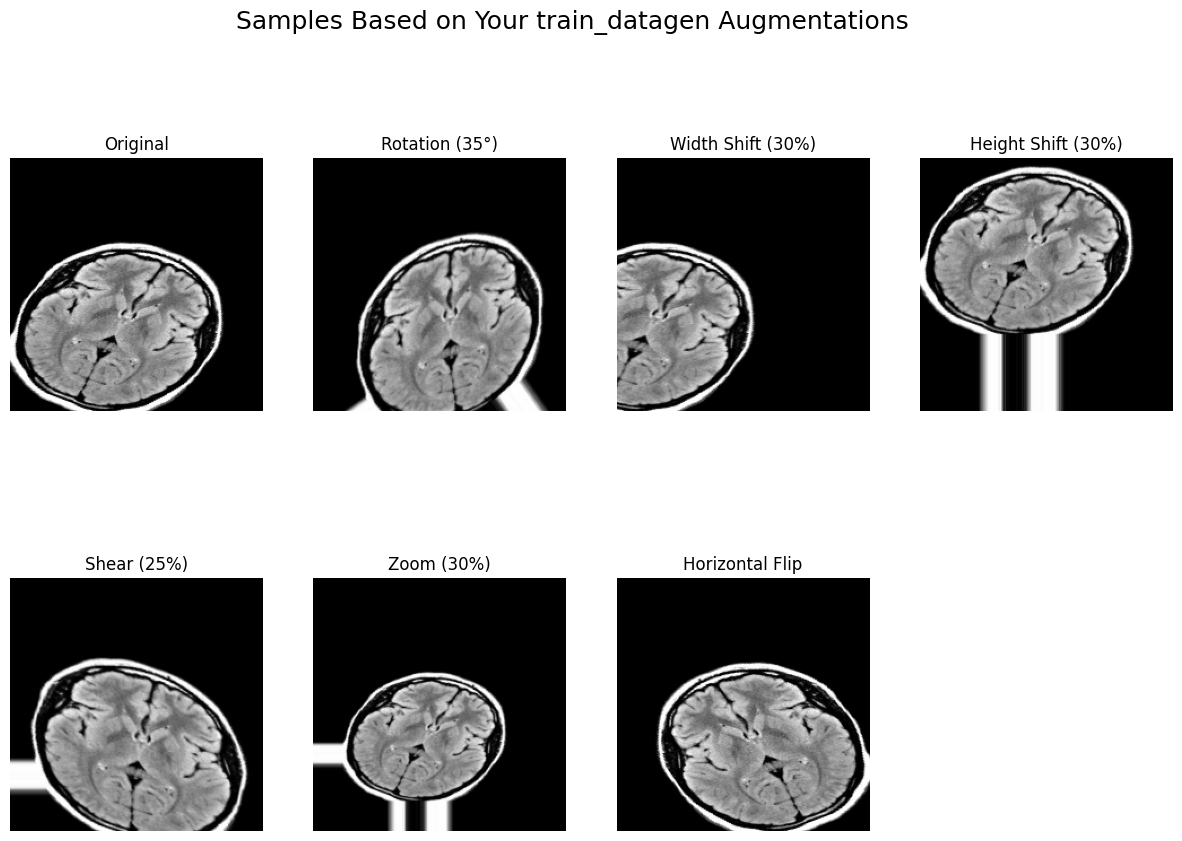

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take one sample image from train generator
x_batch, y_batch = next(train_generator)
img = x_batch[0]

# Apply augmentation rules from train_datagen manually
def apply_rotation(img):
    return train_datagen.apply_transform(img, {'theta': 35})

def apply_width_shift(img):
    shift = 0.3 * img.shape[1]
    return train_datagen.apply_transform(img, {'tx': shift})

def apply_height_shift(img):
    shift = 0.3 * img.shape[0]
    return train_datagen.apply_transform(img, {'ty': shift})

def apply_shear(img):
    return train_datagen.apply_transform(img, {'shear': 0.25 * 100})

def apply_zoom(img):
    zoom = 1 + 0.3
    return train_datagen.apply_transform(img, {'zx': zoom, 'zy': zoom})

def apply_flip(img):
    return train_datagen.apply_transform(img, {'flip_horizontal': True})


# Create labeled preview list
augmentations = [
    ("Original", img),
    ("Rotation (35°)", apply_rotation(img)),
    ("Width Shift (30%)", apply_width_shift(img)),
    ("Height Shift (30%)", apply_height_shift(img)),
    ("Shear (25%)", apply_shear(img)),
    ("Zoom (30%)", apply_zoom(img)),
    ("Horizontal Flip", apply_flip(img))
]

# Plot all
plt.figure(figsize=(15, 10))
for i, (title, im) in enumerate(augmentations):
    plt.subplot(2, 4, i+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")

plt.suptitle("Samples Based on Your train_datagen Augmentations", fontsize=18)
plt.show()


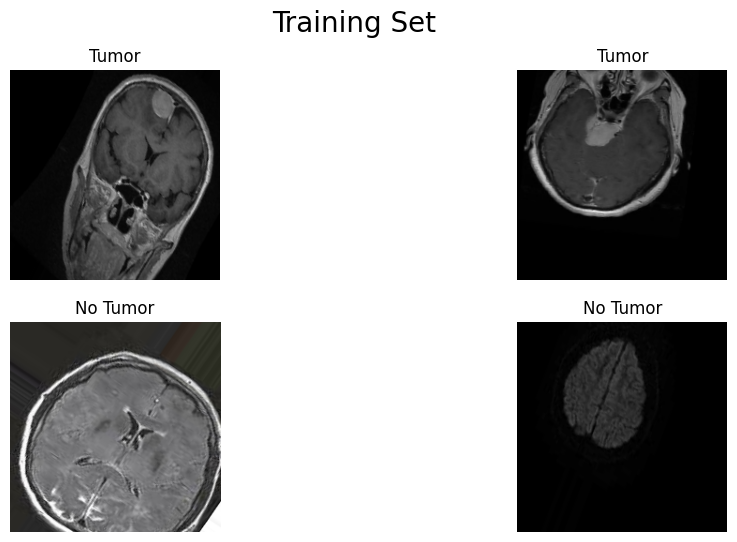

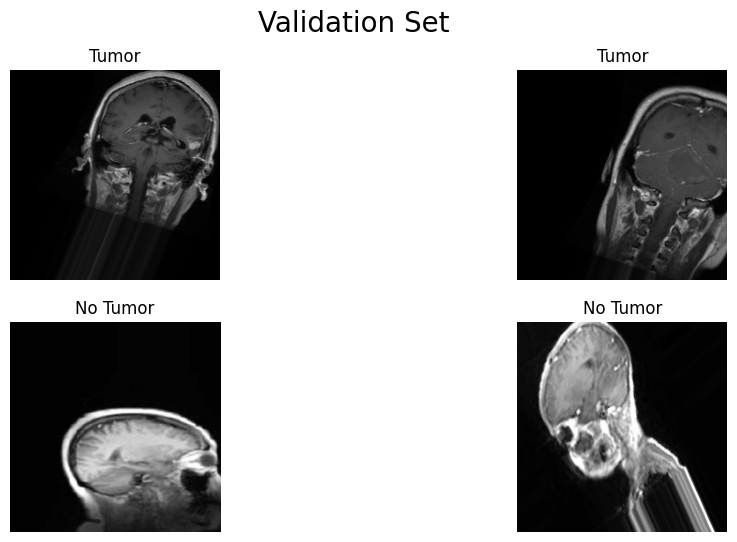

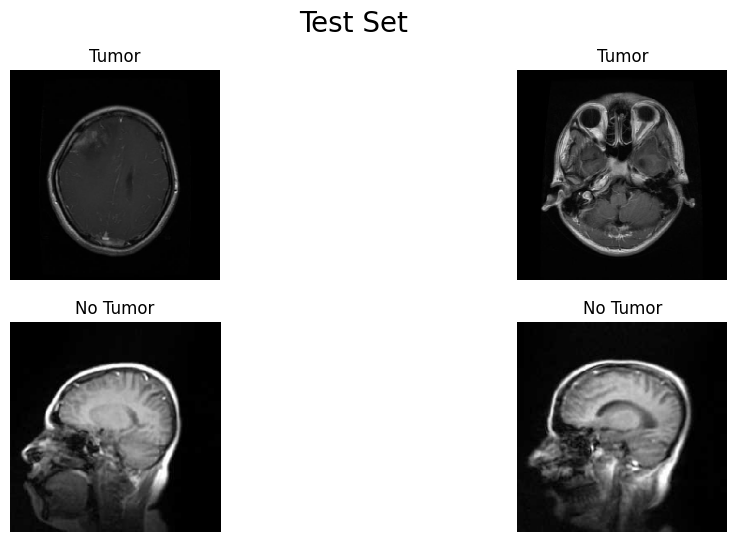

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function: pick tumor & no-tumor images
def get_class_samples(generator, num_samples=2):
    tumor_images = []
    notumor_images = []

    while len(tumor_images) < num_samples or len(notumor_images) < num_samples:
        x_batch, y_batch = next(generator)

        for img, lbl in zip(x_batch, y_batch):
            if lbl == 1 and len(tumor_images) < num_samples:
                tumor_images.append(img)
            elif lbl == 0 and len(notumor_images) < num_samples:
                notumor_images.append(img)

            if len(tumor_images) == num_samples and len(notumor_images) == num_samples:
                break

    return tumor_images, notumor_images


# Show images
def show_images(title, tumor_imgs, no_tumor_imgs):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=20)

    # Tumor images
    for i, img in enumerate(tumor_imgs):
        plt.subplot(2, len(tumor_imgs), i + 1)
        plt.imshow(img)
        plt.title("Tumor")
        plt.axis("off")

    # No tumor images
    for i, img in enumerate(no_tumor_imgs):
        plt.subplot(2, len(no_tumor_imgs), len(tumor_imgs) + i + 1)
        plt.imshow(img)
        plt.title("No Tumor")
        plt.axis("off")

    plt.show()



# TRAINING SET

tumor_train, notumor_train = get_class_samples(train_generator)
show_images("Training Set", tumor_train, notumor_train)


# VALIDATION SET

tumor_val, notumor_val = get_class_samples(val_generator)
show_images("Validation Set", tumor_val, notumor_val)


# TEST SET

tumor_test, notumor_test = get_class_samples(test_generator)
show_images("Test Set", tumor_test, notumor_test)


In [ ]:
# Compute class weights
from collections import Counter
counter = Counter(train_generator.classes)
print("Train class distribution:", counter)
# compute class weights
total = sum(counter.values())
class_weight = {0: total/(2*counter[0]), 1: total/(2*counter[1])}
print("Class weights:", class_weight)

Train class distribution: Counter({np.int32(0): 3328, np.int32(1): 3294})
Class weights: {0: 0.9948918269230769, 1: 1.0051608986035216}


In [ ]:
# Model A - Simple CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import optimizers

def build_simple_cnn(input_shape=IMG_SIZE+(3,)):
    model = Sequential()

    # Convolution Block 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Convolution Block 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Convolution Block 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Global Pooling + Dense
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_a = build_simple_cnn()
model_a.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,425 (497.75 KB)

 Trainable params: 126,977 (496.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#  Model B - VGG16 transfer learning
def build_vgg16_finetune(input_shape=IMG_SIZE+(3,), freeze_until=15):
    base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # freeze some layers
    for layer in base.layers[:freeze_until]:
        layer.trainable = False
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_b = build_vgg16_finetune()
model_b.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Model C - EfficientNetB0 Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import optimizers

def build_efficientnet(input_shape=IMG_SIZE+(3,)):
    # Load EfficientNetB0 base
    base_model = EfficientNetB0(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape)

    # Freeze base model
    base_model.trainable = False

    # Custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model_c = build_efficientnet()
model_c.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,382,884 (16.72 MB)

 Trainable params: 330,753 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Model D - DenseNet121 Transfer Learning
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers

def build_densenet121(input_shape=IMG_SIZE+(3,), fine_tune_at=100):

    # Load DenseNet121 base
    base = DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=input_shape)

    # Freeze all layers initially
    for layer in base.layers:
        layer.trainable = False

    # Custom top layers
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=base.input, outputs=out)

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model_d = build_densenet121()
model_d.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Model E - ResNet50 Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

def build_resnet50(input_shape=IMG_SIZE+(3,)):
    # Load ResNet50 base
    base_model = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)

    # Freeze base model
    base_model.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model_e = build_resnet50()
model_e.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,120,705 (92.01 MB)

 Trainable params: 528,897 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
# Training function & train the 5 models (separately)

def train_model(model, name, epochs):
    print(f"Training {name} ...")
    history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // BATCH_SIZE,
        validation_data = val_generator,
        validation_steps = max(1, val_generator.samples // BATCH_SIZE),
        epochs = epochs,
        class_weight = class_weight,
    )

    model.save(f'{name}_final.h5')
    return history


#  Simple CNN
hist_a = train_model(model_a, 'simple_cnn', epochs=8)

# VGG16
hist_b = train_model(model_b, 'vgg16', epochs=8)

# EfficientNetB0
hist_c = train_model(model_c, 'efficientnetb0', epochs=8)

# DENSENET121
hist_d = train_model(model_d, 'densenet121', epochs=8)

# RESNET50
hist_e = train_model(model_e, 'resnet50', epochs=8)

Training simple_cnn ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 122s 276ms/step - accuracy: 0.7898 - loss: 0.4820 - val_accuracy: 0.3732 - val_loss: 0.8412
Epoch 2/8
  1/413 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9375 - loss: 0.2830

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9375 - loss: 0.2830 - val_accuracy: 0.3823 - val_loss: 0.8369
Epoch 3/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 147s 355ms/step - accuracy: 0.9021 - loss: 0.2697 - val_accuracy: 0.8119 - val_loss: 0.4381
Epoch 4/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.8750 - loss: 0.2234 - val_accuracy: 0.7609 - val_loss: 0.5344
Epoch 5/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 145s 287ms/step - accuracy: 0.9267 - loss: 0.2181 - val_accuracy: 0.8313 - val_loss: 0.4633
Epoch 6/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.9375 - loss: 0.0963 - val_accuracy: 0.8289 - val_loss: 0.4720
Epoch 7/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 123s 298ms/step - accuracy: 0.9357 - loss: 0.1900 - val_accuracy: 0.8119 - val_loss: 0.4635
Epoch 8/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9375 - loss: 0.1213 - val_accuracy: 0.8513 - val_loss: 0.4059


Training vgg16 ...
Epoch 1/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 146s 322ms/step - accuracy: 0.7332 - loss: 0.5054 - val_accuracy: 0.8786 - val_loss: 0.2708
Epoch 2/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.9375 - loss: 0.1255 - val_accuracy: 0.8908 - val_loss: 0.2607
Epoch 3/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 141s 342ms/step - accuracy: 0.9546 - loss: 0.1390 - val_accuracy: 0.8046 - val_loss: 0.4701
Epoch 4/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 1.0000 - loss: 0.0737 - val_accuracy: 0.8095 - val_loss: 0.4354
Epoch 5/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 123s 297ms/step - accuracy: 0.9614 - loss: 0.1245 - val_accuracy: 0.9375 - val_loss: 0.1770
Epoch 6/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.9375 - loss: 0.0779 - val_accuracy: 0.9369 - val_loss: 0.1820
Epoch 7/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 122s 296ms/step - accuracy: 0.9693 - loss: 0.1008 - val_accuracy: 0.8944 - val_loss: 0.2532
Epoch 8/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.875

Training efficientnetb0 ...
Epoch 1/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 155s 311ms/step - accuracy: 0.5206 - loss: 0.7502 - val_accuracy: 0.5049 - val_loss: 0.6888
Epoch 2/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.6875 - loss: 0.6429 - val_accuracy: 0.5049 - val_loss: 0.6888
Epoch 3/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 105s 254ms/step - accuracy: 0.5281 - loss: 0.7254 - val_accuracy: 0.7409 - val_loss: 0.6770
Epoch 4/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.5000 - loss: 0.7341 - val_accuracy: 0.7427 - val_loss: 0.6773
Epoch 5/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 105s 253ms/step - accuracy: 0.5261 - loss: 0.7077 - val_accuracy: 0.7306 - val_loss: 0.6680
Epoch 6/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3125 - loss: 0.8291 - val_accuracy: 0.7233 - val_loss: 0.6679
Epoch 7/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 142s 344ms/step - accuracy: 0.5418 - loss: 0.7030 - val_accuracy: 0.6632 - val_loss: 0.6690
Epoch 8/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accura

Training densenet121 ...
Epoch 1/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 164s 337ms/step - accuracy: 0.7923 - loss: 0.4335 - val_accuracy: 0.8028 - val_loss: 0.3953
Epoch 2/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.8750 - loss: 0.1632 - val_accuracy: 0.8028 - val_loss: 0.4018
Epoch 3/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 115s 278ms/step - accuracy: 0.9319 - loss: 0.1914 - val_accuracy: 0.8380 - val_loss: 0.3480
Epoch 4/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 1.0000 - loss: 0.0548 - val_accuracy: 0.8392 - val_loss: 0.3289
Epoch 5/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 113s 275ms/step - accuracy: 0.9459 - loss: 0.1384 - val_accuracy: 0.8350 - val_loss: 0.3434
Epoch 6/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 1.0000 - loss: 0.0522 - val_accuracy: 0.8386 - val_loss: 0.3565
Epoch 7/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 112s 272ms/step - accuracy: 0.9515 - loss: 0.1313 - val_accuracy: 0.8665 - val_loss: 0.2918
Epoch 8/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy

Training resnet50 ...
Epoch 1/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 136s 300ms/step - accuracy: 0.7403 - loss: 0.5123 - val_accuracy: 0.7191 - val_loss: 0.5722
Epoch 2/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8750 - loss: 0.2993 - val_accuracy: 0.6936 - val_loss: 0.5747
Epoch 3/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 113s 273ms/step - accuracy: 0.8383 - loss: 0.3896 - val_accuracy: 0.7051 - val_loss: 0.5678
Epoch 4/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.9375 - loss: 0.2069 - val_accuracy: 0.7209 - val_loss: 0.5493
Epoch 5/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 113s 273ms/step - accuracy: 0.8504 - loss: 0.3511 - val_accuracy: 0.7718 - val_loss: 0.4580
Epoch 6/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8750 - loss: 0.2847 - val_accuracy: 0.7761 - val_loss: 0.4509
Epoch 7/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 114s 277ms/step - accuracy: 0.8640 - loss: 0.3365 - val_accuracy: 0.7530 - val_loss: 0.5116
Epoch 8/8
413/413 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.

In [ ]:
 # Evaluation
def evaluate_on_test(model, model_name):
    print(f"Evaluating {model_name} on test set...")
    preds = model.predict(test_generator, steps=test_generator.samples)
    y_pred_prob = preds.ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    y_true = test_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
    cm = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, y_pred_prob, cm

y_true_a, y_pred_a, y_prob_a, cm_a = evaluate_on_test(model_a, 'simple_cnn')
y_true_b, y_pred_b, y_prob_b, cm_b = evaluate_on_test(model_b, 'vgg16')
y_true_c, y_pred_c, y_prob_c, cm_c = evaluate_on_test(model_c, 'efficientnetb0')
y_true_d, y_pred_d, y_prob_d, cm_d = evaluate_on_test(model_d, 'densenet121')
y_true_e, y_pred_e, y_prob_e, cm_e = evaluate_on_test(model_e, 'resnet50')



Evaluating simple_cnn on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1816/1816 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor       0.93      0.88      0.90       910
       tumor       0.89      0.93      0.91       906

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816

Evaluating vgg16 on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor       0.96      0.93      0.95       910
       tumor       0.93      0.96      0.95       906

    accuracy                           0.95      1816
   macro avg       0.95      0.95      0.95      1816
weighted avg       0.95      0.95      0.95      1816

Evaluating efficientnetb0 on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor     

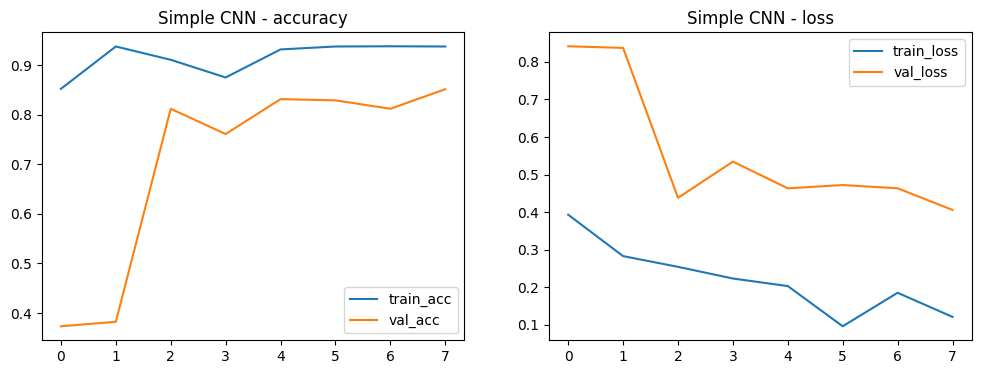

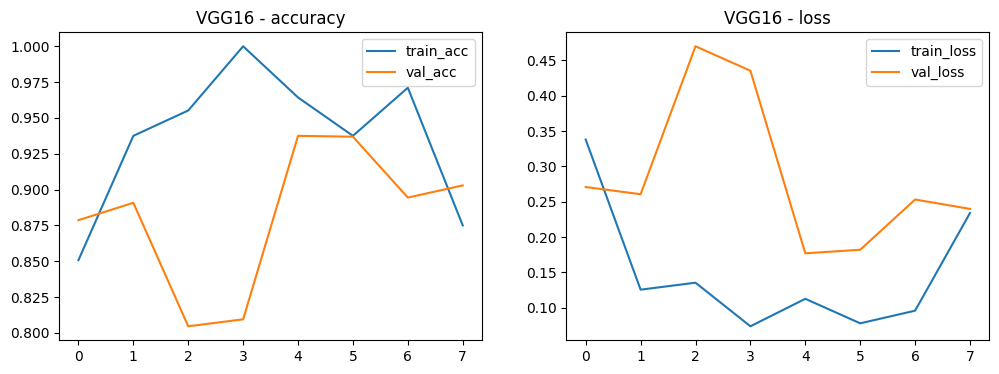

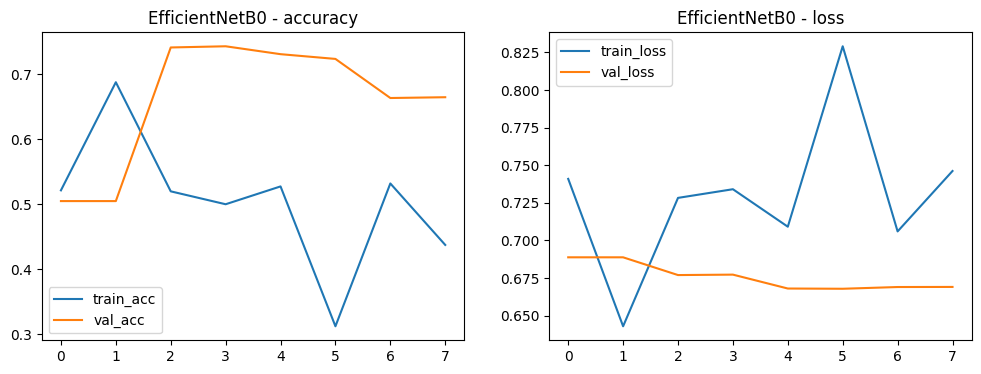

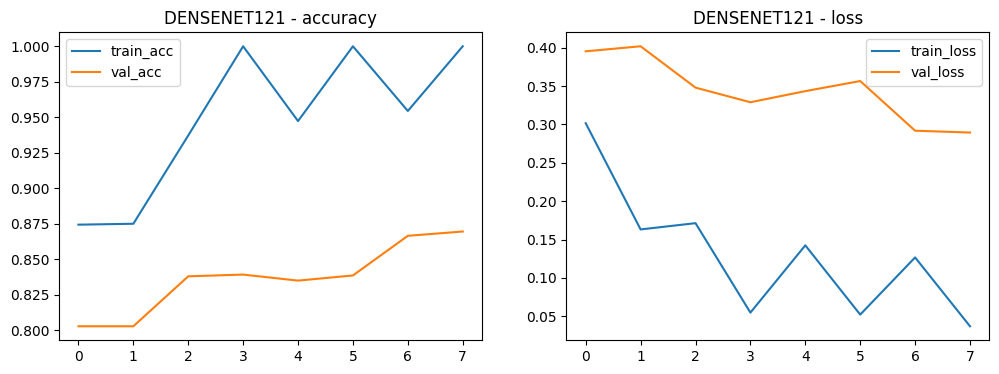

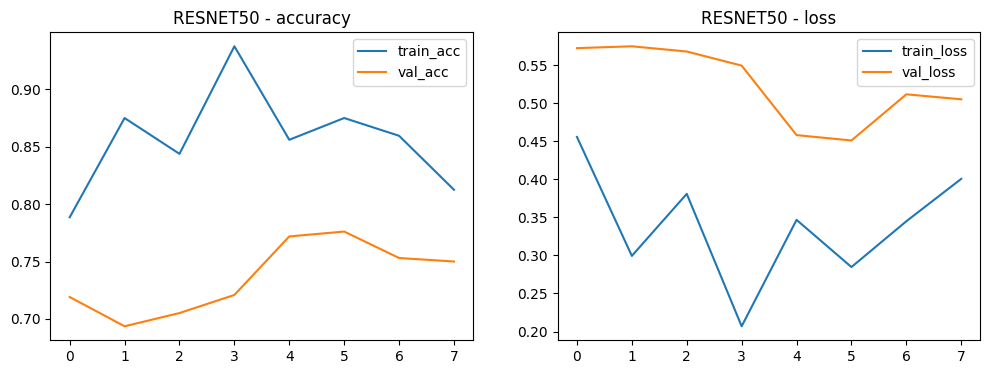

In [ ]:
# Plotting
def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f'{title} - accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{title} - loss')
    plt.legend()
    plt.show()

plot_history(hist_a, 'Simple CNN')
plot_history(hist_b, 'VGG16')
plot_history(hist_c, 'EfficientNetB0')
plot_history(hist_d, 'DENSENET121')
plot_history(hist_e, 'RESNET50')


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Load Base Model
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg_base.trainable = False   # Step 1: Freeze

x = GlobalAveragePooling2D()(vgg_base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

vgg_model = Model(inputs=vgg_base.input, outputs=output)
vgg_model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

print("Training VGG16 top layers (5 epochs)...")
history1 = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# Step 2: Unfreeze last block
for layer in vgg_base.layers[-4:]:   # last conv block
    layer.trainable = True

vgg_model.compile(optimizer=Adam(1e-5), loss="binary_crossentropy", metrics=["accuracy"])

print("Fine-tuning VGG16 full model (10 epochs)...")
history2 = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

vgg_model.save("VGG16_finetuned.h5")


Training VGG16 top layers (5 epochs)...
Epoch 1/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 128s 304ms/step - accuracy: 0.5165 - loss: 0.7227 - val_accuracy: 0.5378 - val_loss: 0.6886
Epoch 2/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 120s 289ms/step - accuracy: 0.5779 - loss: 0.6731 - val_accuracy: 0.5613 - val_loss: 0.6881
Epoch 3/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 120s 290ms/step - accuracy: 0.6404 - loss: 0.6407 - val_accuracy: 0.5462 - val_loss: 0.6873
Epoch 4/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 120s 290ms/step - accuracy: 0.6952 - loss: 0.6153 - val_accuracy: 0.5438 - val_loss: 0.6901
Epoch 5/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 121s 292ms/step - accuracy: 0.7559 - loss: 0.5843 - val_accuracy: 0.5511 - val_loss: 0.6885
Fine-tuning VGG16 full model (10 epochs)...
Epoch 1/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 129s 304ms/step - accuracy: 0.8761 - loss: 0.3358 - val_accuracy: 0.8894 - val_loss: 0.2571
Epoch 2/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 120s 290ms/step - accuracy: 0.9584 - loss: 0.1234 - val_accuracy: 0.8659 - val_loss: 0.30

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Base Model
dense_base = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))
dense_base.trainable = False

x = GlobalAveragePooling2D()(dense_base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

dense_model = Model(inputs=dense_base.input, outputs=output)
dense_model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

print("Training DenseNet top layers (5 epochs)...")
history1 = dense_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


# Step 2: Unfreeze last 50 layers
for layer in dense_base.layers[-50:]:
    layer.trainable = True

dense_model.compile(optimizer=Adam(1e-5), loss="binary_crossentropy", metrics=["accuracy"])

print("Fine-tuning DenseNet full model (10 epochs)...")
history2 = dense_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

dense_model.save("DenseNet_finetuned.h5")


Training DenseNet top layers (5 epochs)...
Epoch 1/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 173s 363ms/step - accuracy: 0.5470 - loss: 0.7485 - val_accuracy: 0.7202 - val_loss: 0.5634
Epoch 2/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 119s 287ms/step - accuracy: 0.8278 - loss: 0.4253 - val_accuracy: 0.7299 - val_loss: 0.5320
Epoch 3/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 113s 274ms/step - accuracy: 0.8764 - loss: 0.3359 - val_accuracy: 0.7432 - val_loss: 0.5015
Epoch 4/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 114s 275ms/step - accuracy: 0.8998 - loss: 0.2823 - val_accuracy: 0.7474 - val_loss: 0.5013
Epoch 5/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 113s 273ms/step - accuracy: 0.9040 - loss: 0.2618 - val_accuracy: 0.7601 - val_loss: 0.4724
Fine-tuning DenseNet full model (10 epochs)...
Epoch 1/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 190s 375ms/step - accuracy: 0.8924 - loss: 0.2686 - val_accuracy: 0.8145 - val_loss: 0.3890
Epoch 2/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 116s 280ms/step - accuracy: 0.9251 - loss: 0.2051 - val_accuracy: 0.8399 - val_loss

In [ ]:
 # Again Evaluation
def evaluate_on_test(model, model_name):
    print(f"Evaluating {model_name} on test set...")
    preds = model.predict(test_generator, steps=test_generator.samples)
    y_pred_prob = preds.ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    y_true = test_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
    cm = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, y_pred_prob, cm

y_true_a, y_pred_a, y_prob_a, cm_a = evaluate_on_test(model_a, 'simple_cnn')
y_true_b, y_pred_b, y_prob_b, cm_b = evaluate_on_test(model_b, 'vgg16')
y_true_c, y_pred_c, y_prob_c, cm_c = evaluate_on_test(model_c, 'efficientnetb0')
y_true_d, y_pred_d, y_prob_d, cm_d = evaluate_on_test(model_d, 'densenet121')
y_true_e, y_pred_e, y_prob_e, cm_e = evaluate_on_test(model_e, 'resnet50')



Evaluating simple_cnn on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor       0.93      0.88      0.90       910
       tumor       0.89      0.93      0.91       906

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816

Evaluating vgg16 on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor       0.96      0.93      0.95       910
       tumor       0.93      0.96      0.95       906

    accuracy                           0.95      1816
   macro avg       0.95      0.95      0.95      1816
weighted avg       0.95      0.95      0.95      1816

Evaluating efficientnetb0 on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step
Classification Report:
              precision    recall  

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Step 1: Load Base Model

eff_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
eff_base.trainable = False   # freeze convolution layers

x = GlobalAveragePooling2D()(eff_base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

eff_model = Model(inputs=eff_base.input, outputs=output)

eff_model.compile(
    optimizer=Adam(1e-4),          # top layers training LR
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("Training EfficientNet top layers (5 epochs)...")
eff_history1 = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


# Step 2: Unfreeze last 50 layers
for layer in eff_base.layers[-50:]:
    layer.trainable = True

eff_model.compile(
    optimizer=Adam(1e-5),          # lower LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("Fine-tuning EfficientNet full model (10 epochs)...")
eff_history2 = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

eff_model.save("EfficientNet_finetuned.h5")


Training EfficientNet top layers (5 epochs)...
Epoch 1/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 155s 327ms/step - accuracy: 0.5011 - loss: 0.6980 - val_accuracy: 0.5027 - val_loss: 0.6930
Epoch 2/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 108s 260ms/step - accuracy: 0.5043 - loss: 0.6972 - val_accuracy: 0.4973 - val_loss: 0.6931
Epoch 3/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 107s 258ms/step - accuracy: 0.5003 - loss: 0.6959 - val_accuracy: 0.4973 - val_loss: 0.6941
Epoch 4/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 106s 257ms/step - accuracy: 0.4963 - loss: 0.6984 - val_accuracy: 0.4973 - val_loss: 0.6929
Epoch 5/5
414/414 ━━━━━━━━━━━━━━━━━━━━ 108s 261ms/step - accuracy: 0.4901 - loss: 0.6985 - val_accuracy: 0.4973 - val_loss: 0.6928
Fine-tuning EfficientNet full model (10 epochs)...
Epoch 1/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 164s 324ms/step - accuracy: 0.5136 - loss: 0.6986 - val_accuracy: 0.5027 - val_loss: 0.7196
Epoch 2/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 110s 264ms/step - accuracy: 0.5152 - loss: 0.6958 - val_accuracy: 0.5027 - 

In [ ]:
 # Also Again Evaluation
def evaluate_on_test(model, model_name):
    print(f"Evaluating {model_name} on test set...")
    preds = model.predict(test_generator, steps=test_generator.samples)
    y_pred_prob = preds.ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    y_true = test_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
    cm = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, y_pred_prob, cm

y_true_a, y_pred_a, y_prob_a, cm_a = evaluate_on_test(model_a, 'simple_cnn')
y_true_b, y_pred_b, y_prob_b, cm_b = evaluate_on_test(model_b, 'vgg16')
y_true_c, y_pred_c, y_prob_c, cm_c = evaluate_on_test(model_c, 'efficientnetb0')
y_true_d, y_pred_d, y_prob_d, cm_d = evaluate_on_test(model_d, 'densenet121')
y_true_e, y_pred_e, y_prob_e, cm_e = evaluate_on_test(model_e, 'resnet50')



Evaluating simple_cnn on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor       0.93      0.88      0.90       910
       tumor       0.89      0.93      0.91       906

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816

Evaluating vgg16 on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step
Classification Report:
              precision    recall  f1-score   support

    no tumor       0.96      0.93      0.95       910
       tumor       0.93      0.96      0.95       906

    accuracy                           0.95      1816
   macro avg       0.95      0.95      0.95      1816
weighted avg       0.95      0.95      0.95      1816

Evaluating efficientnetb0 on test set...
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Classification Report:
              precision    recall  

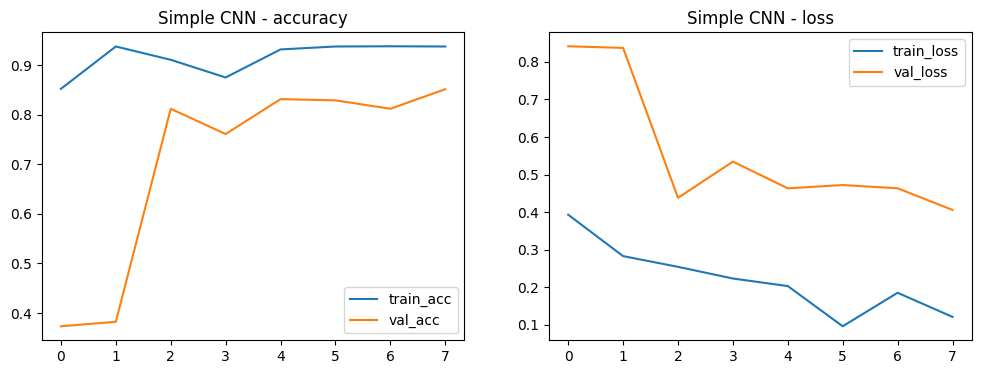

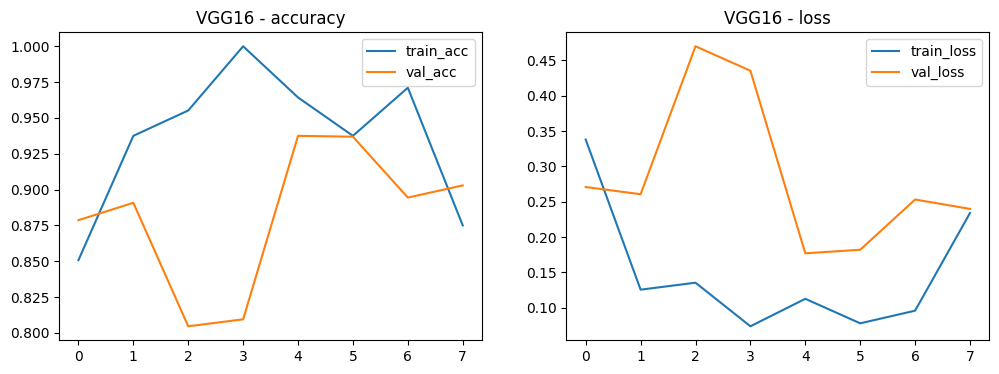

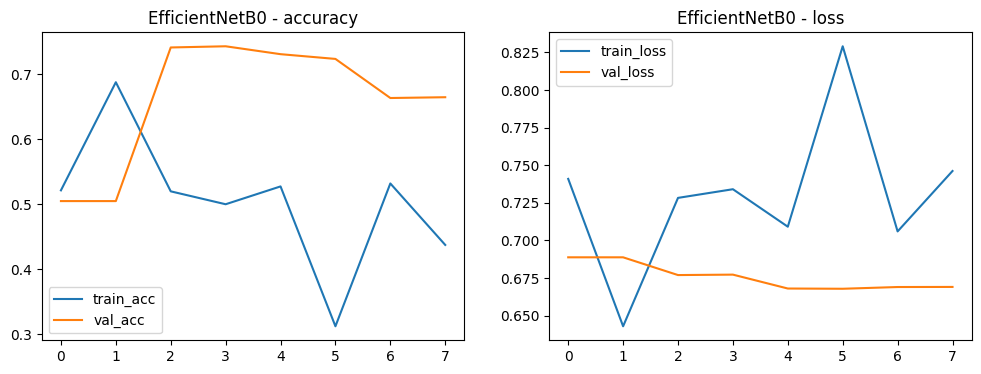

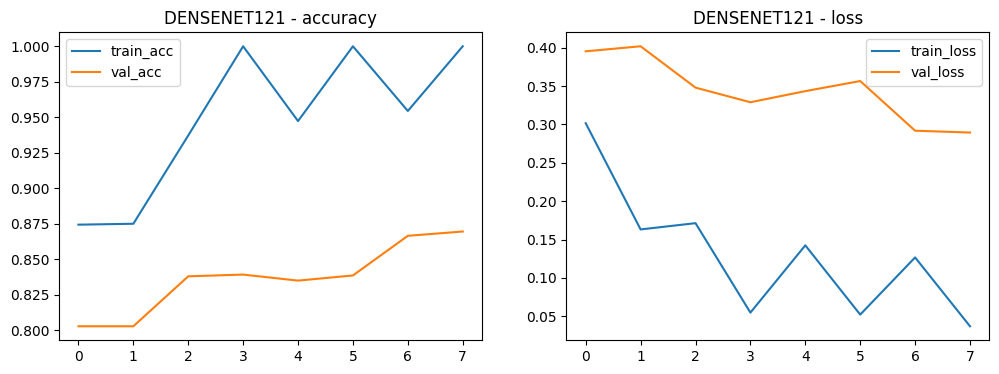

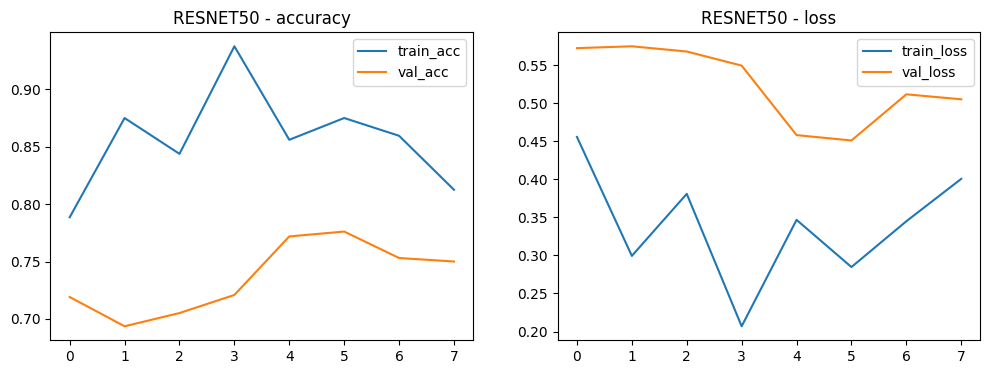

In [ ]:
# Again Updated Plotting
def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f'{title} - accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{title} - loss')
    plt.legend()
    plt.show()

plot_history(hist_a, 'Simple CNN')
plot_history(hist_b, 'VGG16')
plot_history(hist_c, 'EfficientNetB0')
plot_history(hist_d, 'DENSENET121')
plot_history(hist_e, 'RESNET50')


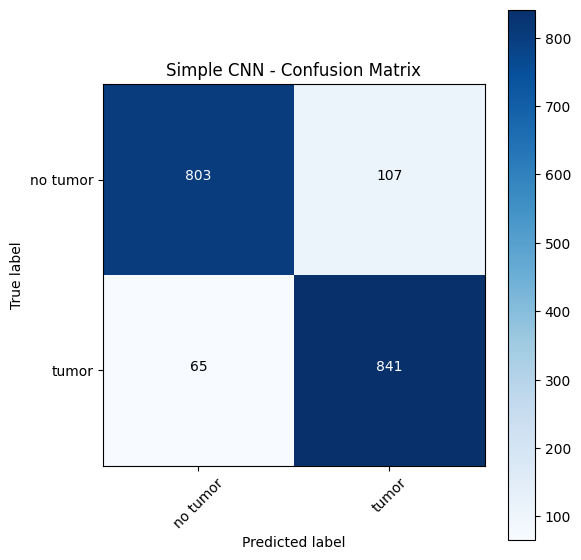

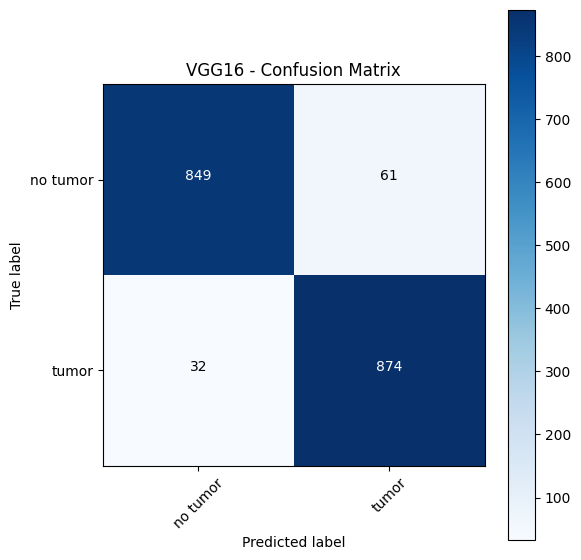

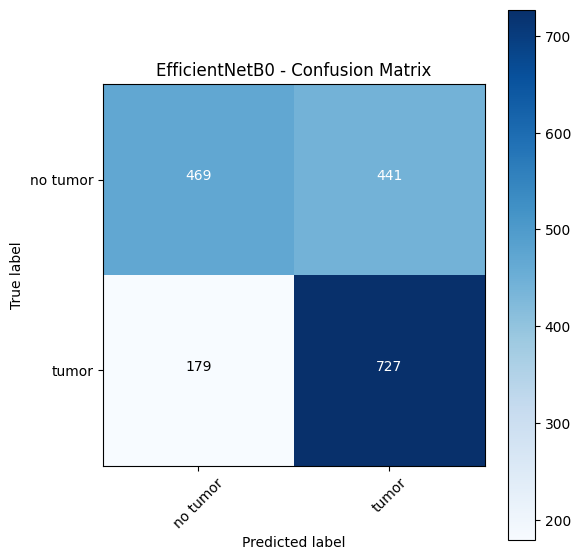

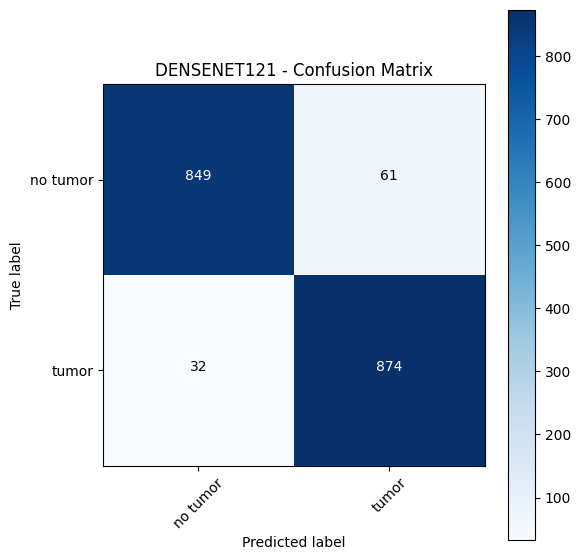

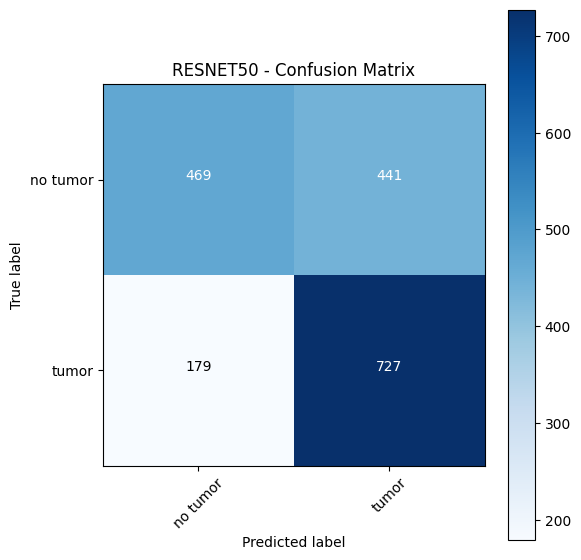

In [ ]:
# Confusion matrix plot
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_a, list(test_generator.class_indices.keys()), 'Simple CNN - Confusion Matrix')
plot_confusion_matrix(cm_b, list(test_generator.class_indices.keys()), 'VGG16 - Confusion Matrix')
plot_confusion_matrix(cm_c, list(test_generator.class_indices.keys()), 'EfficientNetB0 - Confusion Matrix')
plot_confusion_matrix(cm_b, list(test_generator.class_indices.keys()), 'DENSENET121 - Confusion Matrix')
plot_confusion_matrix(cm_c, list(test_generator.class_indices.keys()), 'RESNET50 - Confusion Matrix')




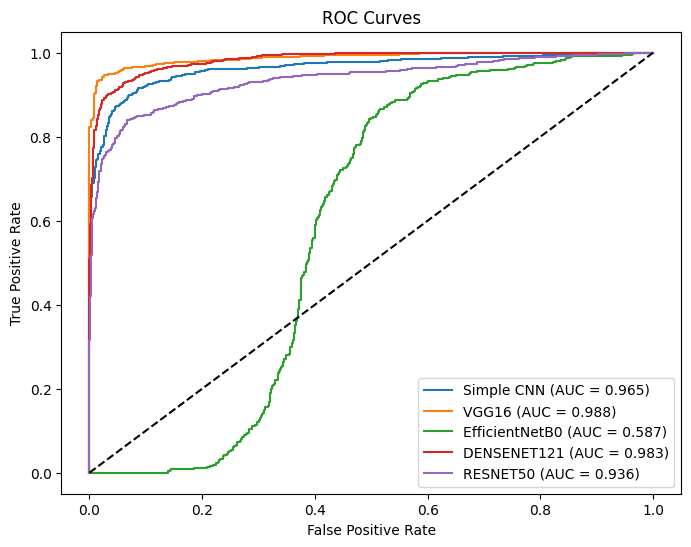

In [ ]:
# ROC curves
def plot_roc(y_true, probs_list, labels):
    plt.figure(figsize=(8,6))
    for probs, lab in zip(probs_list, labels):
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{lab} (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

# using y_true_a (all equal)
plot_roc(y_true_a, [y_prob_a, y_prob_b, y_prob_c, y_prob_d, y_prob_e], ['Simple CNN','VGG16','EfficientNetB0','DENSENET121','RESNET50'])

In [ ]:
# Summary metrics table
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

def summarize_results(y_true, preds, probs, name):
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)

    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    return {
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': roc_auc
    }

# 5 models summary
res_simplecnn = summarize_results(y_true_a, y_pred_a, y_prob_a, 'SimpleCNN')
res_vgg16     = summarize_results(y_true_b, y_pred_b, y_prob_b, 'VGG16')
res_effnet    = summarize_results(y_true_c, y_pred_c, y_prob_c, 'EfficientNetB0')
res_densenet  = summarize_results(y_true_d, y_pred_d, y_prob_d, 'DenseNet121')
res_resnet    = summarize_results(y_true_e, y_pred_e, y_prob_e, 'ResNet50')

import pandas as pd

df = pd.DataFrame([
    res_simplecnn,
    res_vgg16,
    res_effnet,
    res_densenet,
    res_resnet
]).set_index('model')

print(df)


                accuracy  precision    recall        f1       auc
model                                                            
SimpleCNN       0.905286   0.887131  0.928256  0.907228  0.964709
VGG16           0.948789   0.934759  0.964680  0.949484  0.988299
EfficientNetB0  0.658590   0.622432  0.802428  0.701061  0.587002
DenseNet121     0.929515   0.920086  0.940397  0.930131  0.983225
ResNet50        0.880507   0.904818  0.849890  0.876494  0.935840


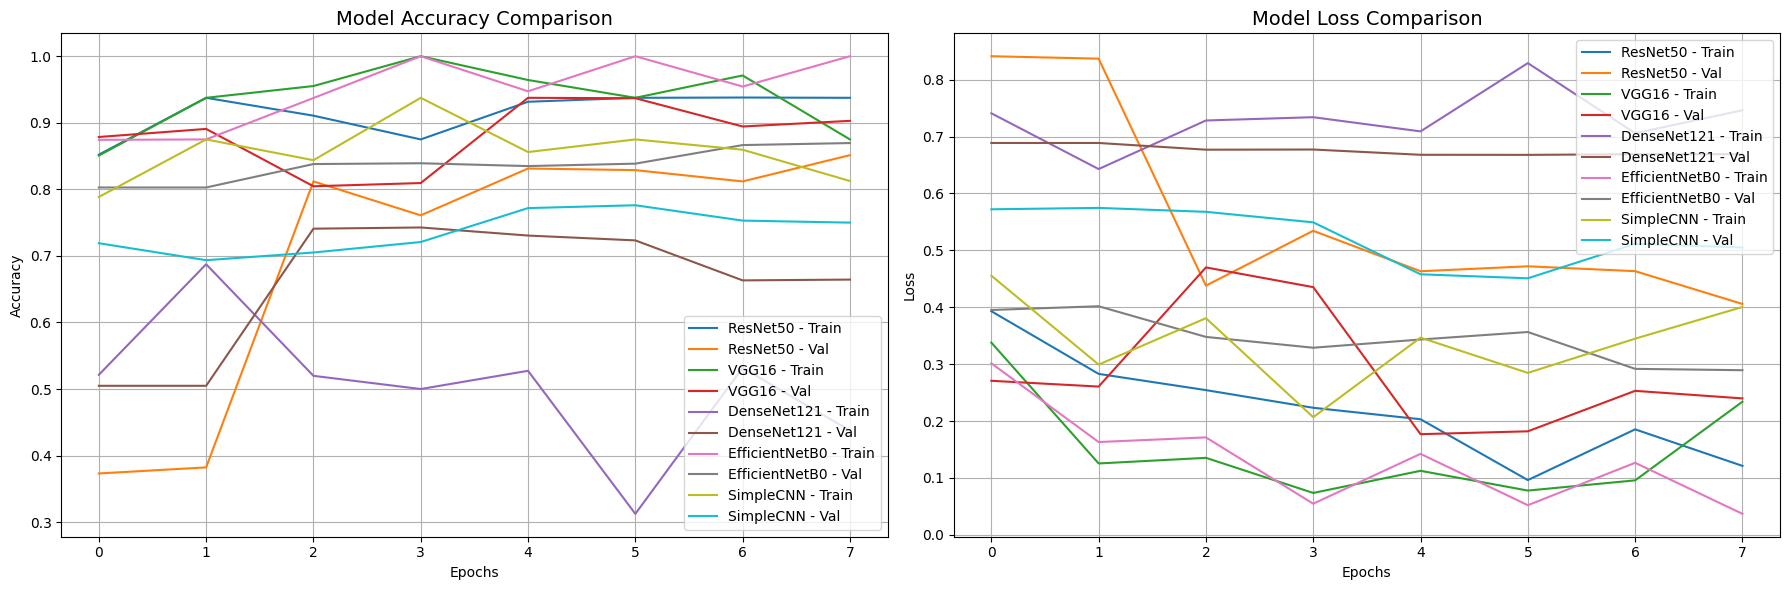

In [ ]:
import matplotlib.pyplot as plt

# MODEL PERFORMANCE COMPARISON (5 Models)

plt.figure(figsize=(18, 6))

# ACCURACY PLOT
plt.subplot(1, 2, 1)
plt.plot(hist_a.history['accuracy'], label='ResNet50 - Train')
plt.plot(hist_a.history['val_accuracy'], label='ResNet50 - Val')

plt.plot(hist_b.history['accuracy'], label='VGG16 - Train')
plt.plot(hist_b.history['val_accuracy'], label='VGG16 - Val')

plt.plot(hist_c.history['accuracy'], label='DenseNet121 - Train')
plt.plot(hist_c.history['val_accuracy'], label='DenseNet121 - Val')

plt.plot(hist_d.history['accuracy'], label='EfficientNetB0 - Train')
plt.plot(hist_d.history['val_accuracy'], label='EfficientNetB0 - Val')

plt.plot(hist_e.history['accuracy'], label='SimpleCNN - Train')
plt.plot(hist_e.history['val_accuracy'], label='SimpleCNN - Val')

plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# LOSS PLOT
plt.subplot(1, 2, 2)
plt.plot(hist_a.history['loss'], label='ResNet50 - Train')
plt.plot(hist_a.history['val_loss'], label='ResNet50 - Val')

plt.plot(hist_b.history['loss'], label='VGG16 - Train')
plt.plot(hist_b.history['val_loss'], label='VGG16 - Val')

plt.plot(hist_c.history['loss'], label='DenseNet121 - Train')
plt.plot(hist_c.history['val_loss'], label='DenseNet121 - Val')

plt.plot(hist_d.history['loss'], label='EfficientNetB0 - Train')
plt.plot(hist_d.history['val_loss'], label='EfficientNetB0 - Val')

plt.plot(hist_e.history['loss'], label='SimpleCNN - Train')
plt.plot(hist_e.history['val_loss'], label='SimpleCNN - Val')

plt.title("Model Loss Comparison", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Training Progress Heatmap

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_training_heatmap(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Combine into table
    data = np.array([acc, val_acc, loss, val_loss])

    plt.figure(figsize=(12, 5))
    sns.heatmap(data, annot=True, cmap="YlGnBu", fmt=".3f",
                yticklabels=["Train Acc", "Val Acc", "Train Loss", "Val Loss"],
                xticklabels=[f"E{e+1}" for e in range(len(acc))])
    plt.title("Training Progress Heatmap")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.show()


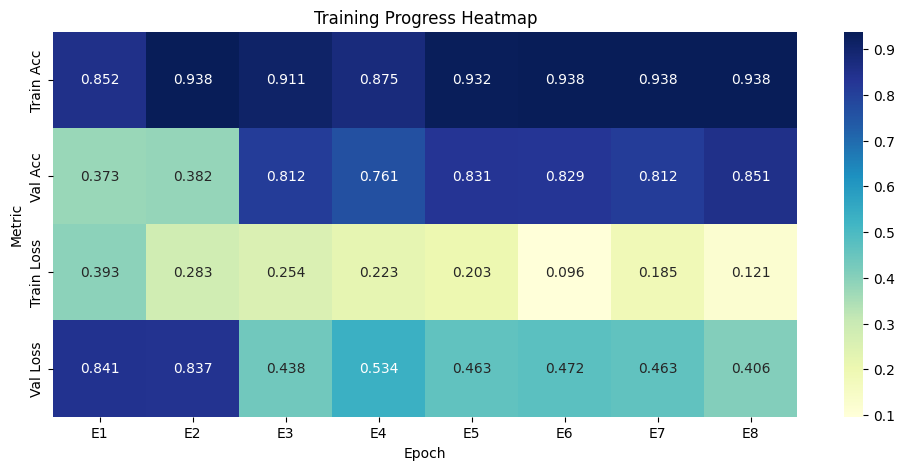

In [ ]:
plot_training_heatmap(hist_a)

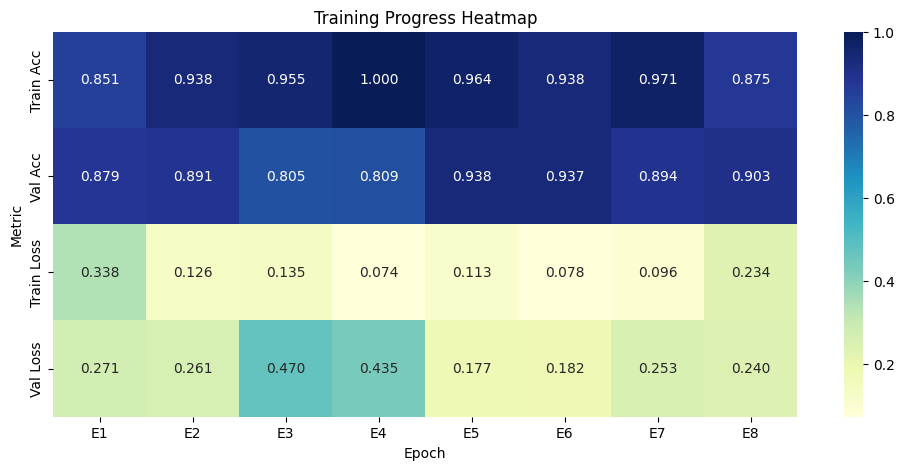

In [ ]:
plot_training_heatmap(hist_b)

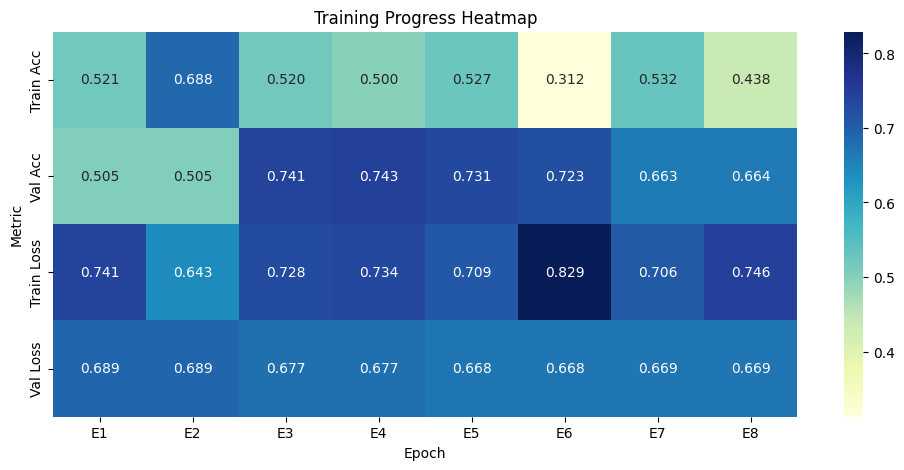

In [ ]:
plot_training_heatmap(hist_c)

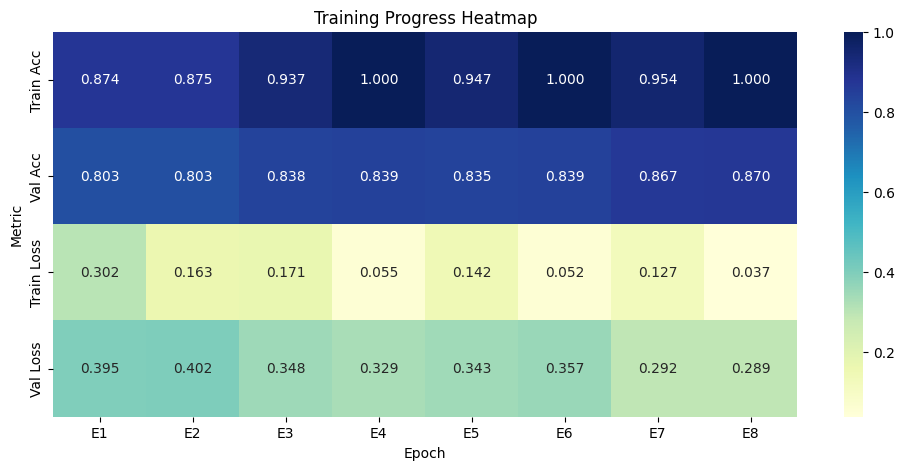

In [ ]:
plot_training_heatmap(hist_d)

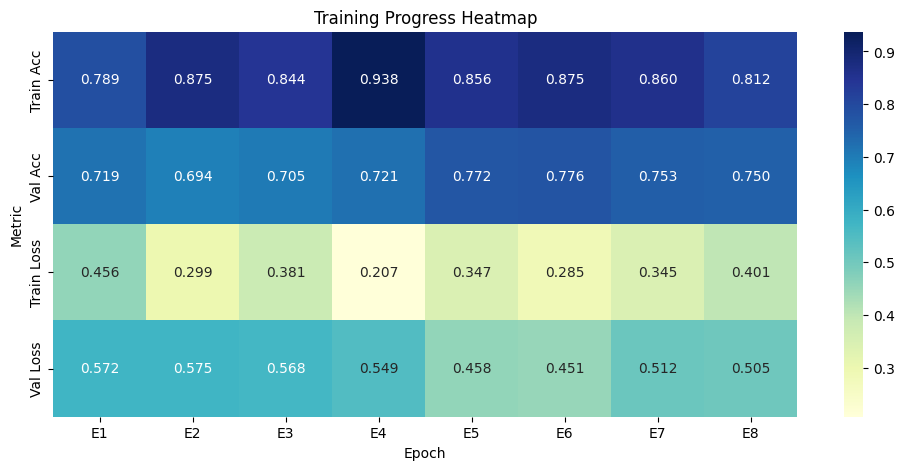

In [ ]:
plot_training_heatmap(hist_e)

In [ ]:
import matplotlib.pyplot as plt

def plot_model_comparison(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
        plt.plot(history.history['accuracy'], linestyle='dotted', label=f'{name} Train Acc')
    plt.title("Model Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
        plt.plot(history.history['loss'], linestyle='dotted', label=f'{name} Train Loss')
    plt.title("Model Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


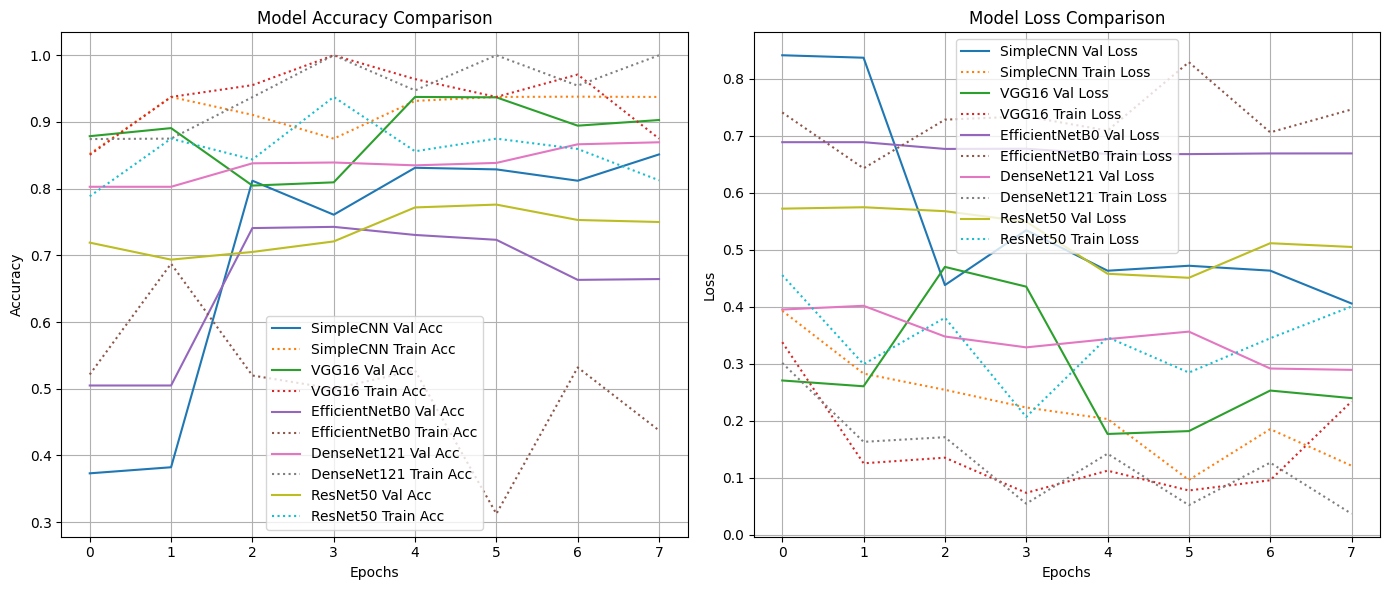

In [ ]:
# List of history objects
histories = [hist_a, hist_b, hist_c, hist_d, hist_e]

# Corresponding model names
model_names = ['SimpleCNN', 'VGG16', 'EfficientNetB0','DenseNet121', 'ResNet50']

# Plot comparison
plot_model_comparison(histories, model_names)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1686']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Grad-CAM generated using last conv layer: block5_conv3


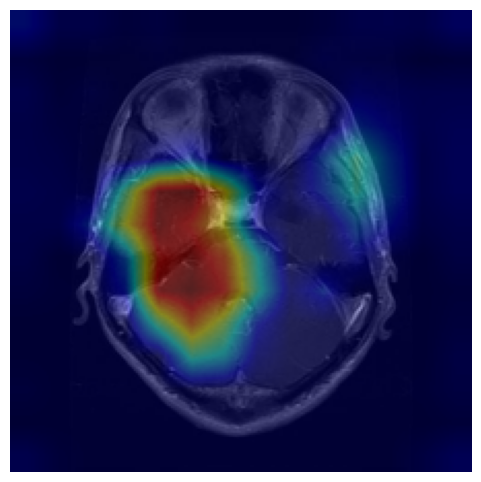

In [ ]:

# Grad-CAM Full Code
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2

def get_last_conv_layer(model):
    """Automatically finds the last Conv2D layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_path, model, last_conv_layer_name=None, img_size=(224,224), preprocess_input=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    # Load image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if preprocess_input:
        img_array = preprocess_input(img_array)
    else:
        img_array /= 255.0

    # Determine last conv layer if not provided
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer(model)

    # Build model that outputs conv layer + predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy(), last_conv_layer_name

def display_gradcam(img_path, heatmap, alpha=0.4, img_size=(224,224)):
    """
    Displays Grad-CAM heatmap overlayed on original image.
    """
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    # Display
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# Example Usage

# Load model (replace with trained model)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=True)

# Path to the image
img_path = '/content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0001.jpg'

# Generate heatmap (preprocess_input is optional)
heatmap, layer_name = make_gradcam_heatmap(img_path, model, preprocess_input=preprocess_input)
print(f"Grad-CAM generated using last conv layer: {layer_name}")

# Display Grad-CAM overlay
display_gradcam(img_path, heatmap, alpha=0.4)



Processing Image 1: /content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0005.jpg
Grad-CAM generated using last conv layer: block5_conv3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1709']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


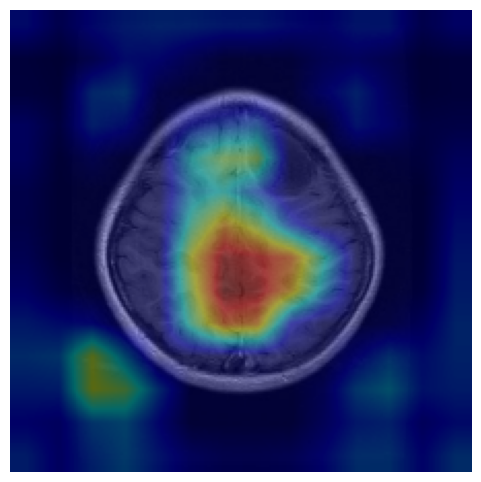


Processing Image 2: /content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0006.jpg
Grad-CAM generated using last conv layer: block5_conv3


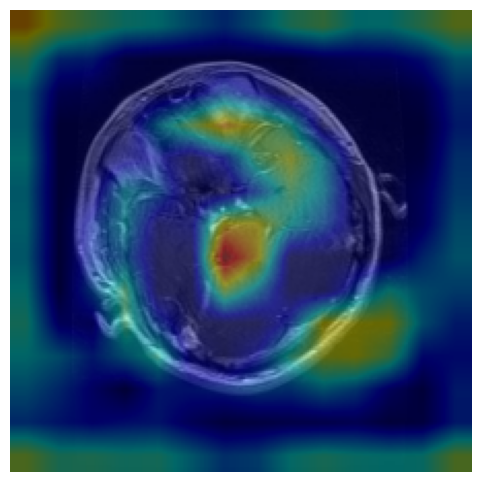


Processing Image 3: /content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0007.jpg
Grad-CAM generated using last conv layer: block5_conv3


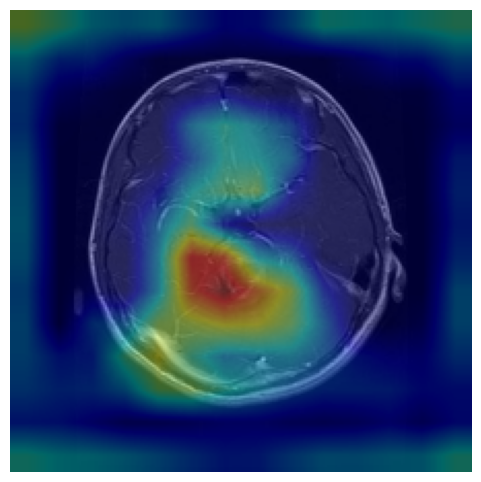


Processing Image 4: /content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0008.jpg
Grad-CAM generated using last conv layer: block5_conv3


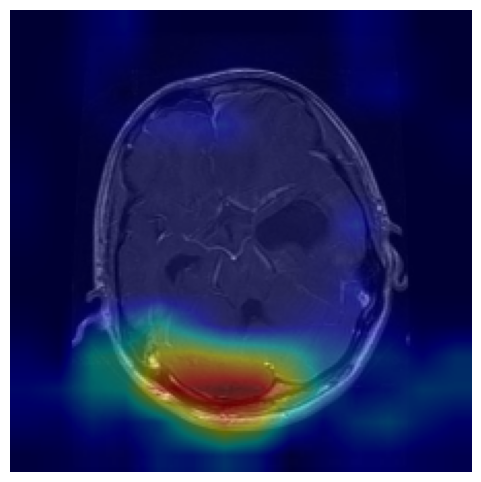

In [ ]:

# Grad-CAM Full Code (Multiple Images)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2

def get_last_conv_layer(model):
    """Automatically finds the last Conv2D layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_path, model, last_conv_layer_name=None, img_size=(224,224), preprocess_input=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    # Load image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if preprocess_input:
        img_array = preprocess_input(img_array)
    else:
        img_array /= 255.0

    # Determine last conv layer if not provided
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer(model)

    # Build model that outputs conv layer + predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy(), last_conv_layer_name

def display_gradcam(img_path, heatmap, alpha=0.4, img_size=(224,224)):
    """
    Displays Grad-CAM heatmap overlayed on original image.
    """
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    # Display
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



# Example Usage


# Load model (replace with trained model)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=True)

# 2️⃣ List of image paths
img_paths = [
    '/content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0005.jpg',
    '/content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0006.jpg',
    '/content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0007.jpg',
    '/content/Brain_Tumor/Dataset/Testing/tumor/Te-glTr_0008.jpg'
]

# 3️⃣ Loop over images and generate Grad-CAM
for i, img_path in enumerate(img_paths):
    print(f"\nProcessing Image {i+1}: {img_path}")
    heatmap, layer_name = make_gradcam_heatmap(img_path, model, preprocess_input=preprocess_input)
    print(f"Grad-CAM generated using last conv layer: {layer_name}")
    display_gradcam(img_path, heatmap, alpha=0.4)
